In [35]:
from joblib import effective_n_jobs

In [89]:
from sklearn.ensemble import BaggingRegressor
from sklearn.utils.validation import check_is_fitted
from sklearn.ensemble._base import _partition_estimators
from sklearn.ensemble._bagging import _parallel_predict_regression, BaseBagging
from joblib import Parallel
from sklearn.utils.fixes import delayed
from sklearn.base import ClassifierMixin, RegressorMixin


def _parallel_predict_regression(estimators, estimators_features, X):
    """Private function used to compute predictions within a job."""
    return [estimator.predict(X[:, features])
        for estimator, features in zip(estimators, estimators_features)]


class UncertaintyEnsembleRegressor(BaggingRegressor):
    def predict(self, X):
        """Predict regression target for X.
        The predicted regression target of an input sample is computed as the
        mean predicted regression targets of the estimators in the ensemble.
        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            The training input samples. Sparse matrices are accepted only if
            they are supported by the base estimator.
        Returns
        -------
        y : ndarray of shape (n_samples,)
            The predicted values.
        """
        check_is_fitted(self)
        # Check data
        X = self._validate_data(
            X,
            accept_sparse=["csr", "csc"],
            dtype=None,
            force_all_finite=False,
            reset=False,
        )

        # Parallel loop
        n_jobs, n_estimators, starts = _partition_estimators(
            self.n_estimators, self.n_jobs
        )

        all_y_hat = Parallel(n_jobs=n_jobs, verbose=self.verbose)(
            delayed(_parallel_predict_regression)(
                self.estimators_[starts[i] : starts[i + 1]],
                self.estimators_features_[starts[i] : starts[i + 1]],
                X,
            )
            for i in range(n_jobs)
        )
        
        #fix this later -> unroll nested lists
        
        gathered = [est for job_res in all_y_hat for est in job_res]
        
        return np.vstack(gathered).T

In [52]:
def a():
    return [a for a in range(10)]

In [65]:
[**[1,2,4] for i in range(10)]

SyntaxError: invalid syntax (2058626915.py, line 1)

In [63]:
*[np.array(19),1]

SyntaxError: can't use starred expression here (416246314.py, line 1)

In [46]:
_parallel_predict_regression??

Signature: _parallel_predict_regression(estimators, estimators_features, X)
Source:   
def _parallel_predict_regression(estimators, estimators_features, X):
    """Private function used to compute predictions within a job."""
    return sum(
        estimator.predict(X[:, features])
        for estimator, features in zip(estimators, estimators_features)
    )
File:      /ssd/scratch/kellner/miniconda3/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py
Type:      function


In [40]:
_partition_estimators(16,4)

(4, [4, 4, 4, 4], [0, 4, 8, 12, 16])

In [41]:
np.full(16, 16 // 16, dtype=int)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [38]:
effective_n_jobs(n_jobs=6)

6

In [6]:
help(UncertaintyEnsembleRegressor)

Help on class UncertaintyEnsembleRegressor in module __main__:

class UncertaintyEnsembleRegressor(sklearn.ensemble._bagging.BaggingRegressor)
 |  UncertaintyEnsembleRegressor(base_estimator=None, n_estimators=10, *, max_samples=1.0, max_features=1.0, bootstrap=True, bootstrap_features=False, oob_score=False, warm_start=False, n_jobs=None, random_state=None, verbose=0)
 |  
 |  A Bagging regressor.
 |  
 |  A Bagging regressor is an ensemble meta-estimator that fits base
 |  regressors each on random subsets of the original dataset and then
 |  aggregate their individual predictions (either by voting or by averaging)
 |  to form a final prediction. Such a meta-estimator can typically be used as
 |  a way to reduce the variance of a black-box estimator (e.g., a decision
 |  tree), by introducing randomization into its construction procedure and
 |  then making an ensemble out of it.
 |  
 |  This algorithm encompasses several works from the literature. When random
 |  subsets of the dat

In [68]:
from lshiftml.feature_utils.parallel import get_features_in_parallel
from rascal.representations import SphericalInvariants as SOAP
from rascal.neighbourlist.structure_manager import mask_center_atoms_by_species
from ase.io import read
import json
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
#load
#frames = read("../../COSMO_project/Shiftml2/CSD-1k_test_md_w_shifts.xyz",index=":",format="extxyz")
#frames = read("../../COSMO_project/make_tensor_data/test_tensor/CSD-500+104-7_shift_tensors.xyz",index=":",format="extxyz")
frames = read("../../COSMO_project/make_tensor_data/train_tensor/CSD-3k+S546_shift_tensors.xyz",index=":",format="extxyz")
frames = frames[::6]

with open("/ssd/scratch/kellner/ShiftML-Light/src/lshiftml/models/RR_model_data/RR_this_work_models/hypers/1_hypers.json","r") as fg:
                hypers = json.load(fg)
tmp = []

for frame in frames:
    numbers = np.unique(frame.numbers)
    
    defined = True
    for number in numbers:
        if number not in [1,6,7,8,16]:
            defined = False
        else:
            continue
    
    if defined:
        tmp.append(frame)

frames = tmp
        
results = {}
for specie in [1,6,7,8]:
    tmp_array = []
    for frame in frames:
        mask_center_atoms_by_species(frame,species_select=[specie])
        tmp_array.append(frame.arrays["cs_iso"][frame.arrays["center_atoms_mask"]])
        del frame.arrays["center_atoms_mask"]
    results[specie] = np.hstack(tmp_array)   
for frame in frames: frame.wrap(eps=1e-12)
#feat
for frame in frames: mask_center_atoms_by_species(frame,species_select=[1])
Xpredict = get_features_in_parallel(frames,SOAP,hypers)
#predict


In [26]:
results[1]

array([18.39, 18.39, 18.39, ..., 26.06, 26.06, 26.06])

In [8]:
Xtrain,Xtest,Ytrain,Ytest = train_test_split(Xpredict,results[1],train_size=0.75)

In [29]:
Xtrain.shape

(17026, 8640)

In [5]:
from sklearn.linear_model import Ridge

In [134]:
model = UncertaintyEnsembleRegressor(base_estimator=Ridge(alpha=0.00001),n_estimators=64,bootstrap=False,max_samples=0.66,max_features=0.66,n_jobs=4)

In [ ]:
model.fit(Xtrain,Ytrain)

In [20]:
model.estimators_[3].predict(Xtrain)

array([28.20621596, 24.37364048, 29.13407567, ..., 27.30800666,
       28.03435682, 26.25195637])

In [39]:
model2 = Ridge(alpha=0.00001)

In [40]:
model2.fit(Xtrain,Ytrain)

Ridge(alpha=1e-05)

In [57]:
Ypredict2 = model2.predict(Xtest)

NameError: name 'model2' is not defined

In [27]:
mean_absolute_error(Ypredict2,Ytest))

NameError: name 'mean_absolute_error' is not defined

In [132]:
Ytest_predict = model.predict(Xtest[:600])

In [76]:
mean_absolute_error((np.sum(Ytest_predict,axis=0)/16),Ytest)

0.21369528658343487

In [96]:
import cProfile

In [124]:
Ytest_pred_arr.shape

(5676, 64)

In [123]:
Ytest_pred_arr = np.vstack(Ytest_predict)

In [100]:
from matplotlib import pyplot as plt

In [129]:
np.sqrt(np.mean(np.abs(np.mean(Ytest_pred_arr,axis=1)-Ytest)**2))

0.3530222567539967

In [126]:
z = np.abs(np.mean(Ytest_pred_arr,axis=1)-Ytest)
std = np.std(Ytest_pred_arr,axis=1,ddof=1)


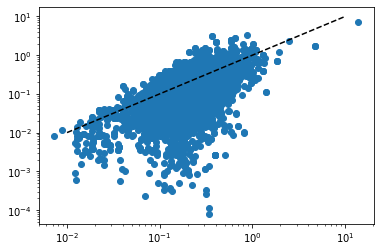

In [133]:
plt.scatter(std,z)
plt.plot(np.logspace(-2,1),np.logspace(-2,1),c="black",linestyle="--")
plt.yscale("log")
plt.xscale("log")


In [99]:
cProfile.run("Ytest_pred_arr_2 = np.vstack(Ytest_predict).T")

         50 function calls (48 primitive calls) in 0.002 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(atleast_2d)
        1    0.000    0.000    0.002    0.002 <__array_function__ internals>:2(concatenate)
        1    0.000    0.000    0.002    0.002 <__array_function__ internals>:2(vstack)
        1    0.000    0.000    0.002    0.002 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 multiarray.py:148(concatenate)
        1    0.000    0.000    0.000    0.000 shape_base.py:207(_arrays_for_stack_dispatcher)
        1    0.000    0.000    0.000    0.000 shape_base.py:218(_vhstack_dispatcher)
        1    0.000    0.000    0.002    0.002 shape_base.py:222(vstack)
        1    0.000    0.000    0.000    0.000 shape_base.py:77(_atleast_2d_dispatcher)
        1    0.000    0.000    0.000    0.000 shape_base.py:81(atleast_2d)
     

In [91]:
Ytest_pred_arr.shape

(5676, 16)

In [77]:
Ytest_predict

[array([28.85642404, 21.43166309, 25.90917912, ..., 26.27594175,
        25.32492778, 26.63795367]),
 array([28.93368911, 21.43770239, 25.77790438, ..., 26.36408385,
        25.98256076, 26.6051287 ]),
 array([28.84623697, 21.55214696, 26.03742927, ..., 26.16851735,
        26.10633477, 26.56136771]),
 array([28.9454782 , 21.57454439, 25.86642631, ..., 26.20618799,
        25.92779018, 26.67656671]),
 array([28.96816858, 21.52131212, 25.94151753, ..., 26.43166807,
        25.6996471 , 26.65496561]),
 array([28.98405291, 21.52432182, 25.81195925, ..., 26.04872971,
        26.07736105, 26.56986235]),
 array([29.06818136, 21.4761263 , 26.35923883, ..., 26.20353751,
        25.99142286, 26.6238453 ]),
 array([28.97420428, 21.46431715, 25.93428261, ..., 26.25708842,
        26.17595207, 26.60960543]),
 array([29.06685872, 21.52113331, 25.95387502, ..., 26.26201608,
        25.75742888, 26.55718367]),
 array([29.08429103, 21.4741021 , 26.03703136, ..., 26.42867613,
        25.78474114, 26.54

In [10]:
mean_absolute_error(Ytest_predict,Ytest)

NameError: name 'mean_absolute_error' is not defined

In [46]:
Xtest.shape

(5676, 8640)

In [ ]:
np.std(Ytest_predict,axis=0)

In [ ]:
np.mean(Ytest_predict,axis=0)

In [29]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [36]:
mean_absolute_error(np.mean(Ytest_predict,axis=0),Ytest)

75.36458217326111

In [37]:
np.mean(Ytest_predict,axis=0)

array([ 62.22064019, 106.04607908, 103.43052958, ...,  93.77745888,
        82.44643906, 116.03518078])

In [23]:
model.n_estimators

16

In [56]:
sum(1,2,3,4)

TypeError: sum() takes at most 2 arguments (4 given)